In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [3]:
feature_vec_list = []
gt_vec_list = []
for i in [0, 1, 2]:
    fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=i, i_indiv=0, mask_thresh=0.5)
    feature_vec_list.append(fe_vec)
    gt_vec_list.append(gt_vec)

(430080, 31, 1) (430080, 1) (430080,)
(430080, 43, 10) (430080, 10) (430080,)
(430080, 37, 18) (430080, 18) (430080,)


In [4]:
permu_index = np.random.permutation(range(len(mask_vec.nonzero()[0])))
dataset_list = []
norm_coef_list = []
gt_norm_coef_list = []
for i in range(len(feature_vec_list)):
    data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(feature_vec_list[i], gt_vec_list[i], mask_vec, 
                                                            permu_index=permu_index)
    dataset_list.append(data_set)
    norm_coef_list.append(norm_coef)
    gt_norm_coef_list.append(gt_norm_coef)

(21485, 1, 31)
(21485, 1)
(5372, 1, 31)
(5372, 1)
(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)
(21485, 18, 37)
(21485, 18)
(5372, 18, 37)
(5372, 18)


In [5]:
gt_norm_coef_list

[67.089485, 3.4137914, 0.44334802]

In [6]:
dataset_list[1][1].shape

(21485, 10)

In [7]:
train_feture_vec_list = [np.concatenate([dataset_list[0][0], np.zeros_like(dataset_list[0][0])], axis=1),
                         dataset_list[1][0], dataset_list[2][0]]
train_gt_vec = dataset_list[1][1]
test_feature_vec_list = [np.concatenate([dataset_list[0][2], np.zeros_like(dataset_list[0][2])], axis=1),
                         dataset_list[1][2], dataset_list[2][2]]
test_gt_vec = dataset_list[1][3]

In [15]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4], j_output=2, n_input_tensors_list=[31, 43, 37],
        n_hidden_tensors=128, func_key_list=['relu', 'linear'])

results = compling_multiorder.compile(
        train_feture_vec_list, train_gt_vec, test_feature_vec_list, test_gt_vec,
        model=nn, make_updates=optimizers.adam)

[(0, 2), (2, 2), (2, 4), (4, 4)]
(0, 2)
(2, 2)
(2, 4)
(4, 4)
[(0, 2), (2, 2), (2, 4), (4, 4)]

/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:65: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/comp

/home/matsui-k/projects/d-rcn/scripts/core/compling_multiorder.py:71: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 4 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


In [16]:
f_train, f_training_error, f_test_error, f_output, param_list = results

In [ ]:
batch_size = 1024
N = dataset_list[0][0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = dataset_list[0][2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 301
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.0619650967419 0.0640568435192
10 0.0122119439766 0.0153286401182
20 0.00858000479639 0.0117056341842
30 0.00676935911179 0.0106018204242
40 0.00588288111612 0.0103694712743
50 0.0056037241593 0.010105044581
60 0.00494191376492 0.00990323908627
70 0.00512948213145 0.00998083036393
80 0.00431298417971 0.00997857376933
90 0.00417898362502 0.00966310687363
100 0.00420531118289 0.00994279514998
110 0.00421199435368 0.0101921511814
120 0.00417650444433 0.0101165650412
130

0 (0.097055159509181976, 0.097874917089939117)
1 (0.061965096741914749, 0.064056843519210815)
2 (0.012211943976581097, 0.01532864011824131)
3 (0.0085800047963857651, 0.01170563418418169)
4 (0.0067693591117858887, 0.010601820424199104)
5 (0.0058828811161220074, 0.010369471274316311)
6 (0.0056037241593003273, 0.010105044580996037)
7 (0.004941913764923811, 0.0099032390862703323)
8 (0.0051294821314513683, 0.0099808303639292717)
9 (0.0043129841797053814, 0.0099785737693309784)
10 (0.0041789836250245571, 0.0096631068736314774)
11 (0.0042053111828863621, 0.0099427951499819756)
12 (0.0042119943536818027, 0.010192151181399822)
13 (0.0041765044443309307, 0.01011656504124403)
14 (0.003806534456089139, 0.0098928483203053474)
15 (0.0036472347564995289, 0.0092468094080686569)
16 (0.00355897331610322, 0.0094381822273135185)
17 (0.0035041880328208208, 0.010169724933803082)
18 (0.0035227560438215733, 0.0099275996908545494)
19 (0.0037011019885540009, 0.0096819046884775162)
20 (0.0033609678503125906, 0.0

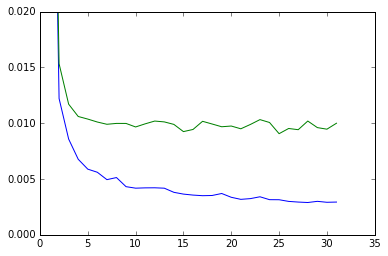

In [24]:
for i, e in enumerate(zip(training_error_array, test_error_array)):
    print i, e
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.02)
plt.hlines(0.0411, 0, training_error_array.shape[0])

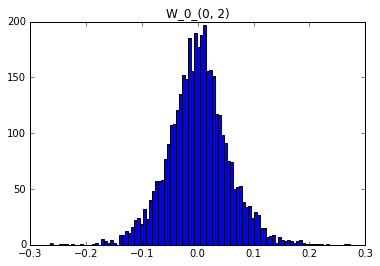

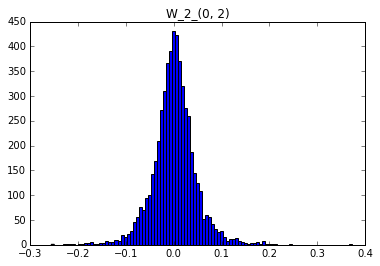

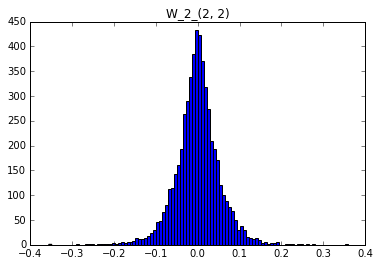

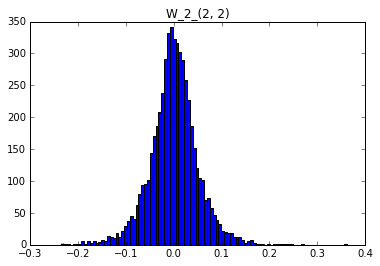

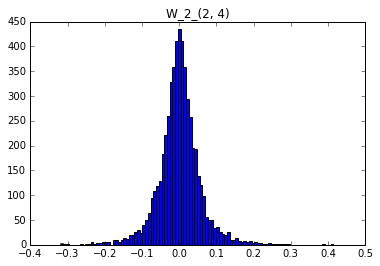

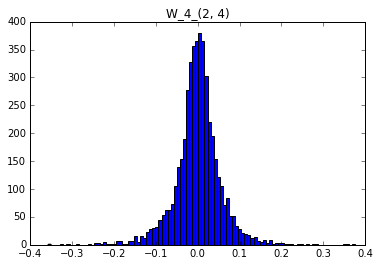

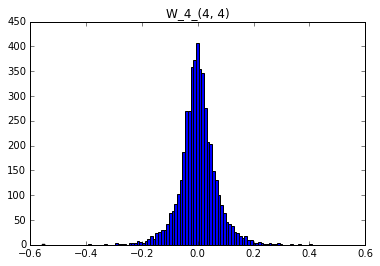

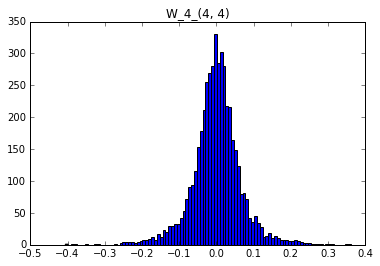

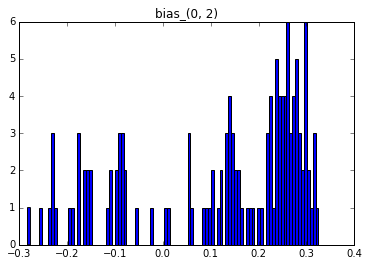

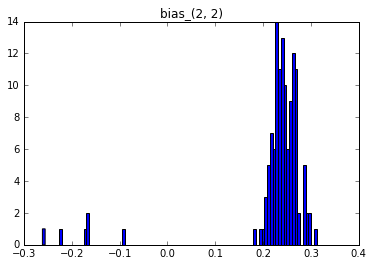

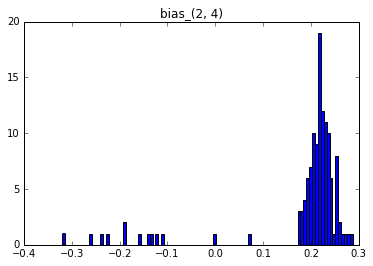

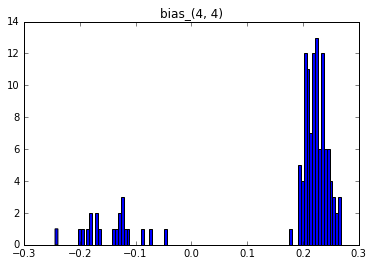

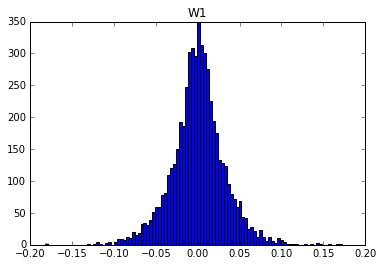

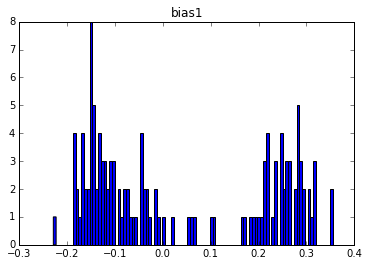

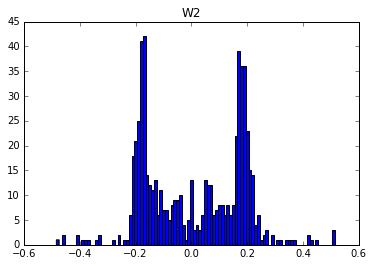

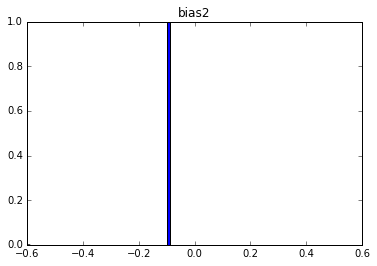

In [33]:
for param in param_list:
    plt.figure()
    plt.title(param.name)
    plt.hist(param.get_value().flatten(), bins=100)

In [47]:
feature_vec_list[0] = np.concatenate([feature_vec_list[0], np.zeros_like(feature_vec_list[0])], axis=2)

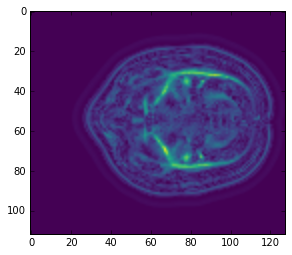

In [55]:
pred_train = TN_utils.predict_original_feature_multiorder(f_output, feature_vec_list, norm_coef_list, out_dim=10)
pred_train_vol = TN_utils.vec2vol(pred_train, vol_shape)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

In [57]:
test_feature_vec_list = []
test_gt_vec_list = []
for i in [0, 1, 2]:
    fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=i, i_indiv=1, mask_thresh=0.5)
    test_feature_vec_list.append(fe_vec)
    test_gt_vec_list.append(gt_vec)

(430080, 31, 1) (430080, 1) (430080,)
(430080, 43, 10) (430080, 10) (430080,)
(430080, 37, 18) (430080, 18) (430080,)


In [58]:
test_feature_vec_list[0] = np.concatenate([test_feature_vec_list[0], np.zeros_like(test_feature_vec_list[0])], axis=2)

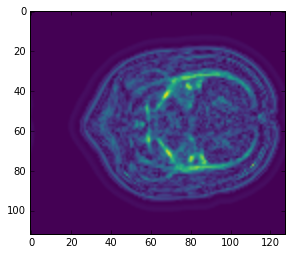

In [59]:
pred_test = TN_utils.predict_original_feature_multiorder(f_output, test_feature_vec_list, norm_coef_list, out_dim=10)
pred_test_vol = TN_utils.vec2vol(pred_test, vol_shape)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [60]:
sio.savemat('../../../results/hardi_in_ex/July10_2_024/a2_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/July10_2_024/a2_all_test_1507.mat', {'pred' : pred_test_vol}) 